### Setup (I)

Before running any of the below blocks, **follow these steps:**
1. Create an account at https://huggingface.co
2. Create an access token with write permissions at https://huggingface.co/settings/tokens
3. Register that you agree to the terms at https://huggingface.co/CompVis/stable-diffusion-v1-4

### Setup (II)

Make sure you are using a GPU runtime to run this notebook, so inference is much faster. If the following command fails, use the `Runtime` menu above and select `Change runtime type`.

In [ ]:
!nvidia-smi

Then **run each of the following blocks of code:**

In [ ]:
!pip install diffusers==0.2.4
!pip install transformers scipy ftfy
!pip install "ipywidgets>=7,<8"

from google.colab import output
output.enable_custom_widget_manager()

from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16, use_auth_token=True)
pipe = pipe.to("cuda")

### Generation

And generate a single image with a given prompt here:

In [ ]:
prompt = "hourly thoroughbred, a surrealist painting by Pablo Picasso, hypnotic, lovecraftian" # <--- !!!

with autocast("cuda"):
  image = pipe(prompt)["sample"][0]

image

If you want to generate a grid of images, **run this once:**

In [ ]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

Then to generate a grid of images with a given prompt:

In [ ]:
num_cols = 3
num_rows = 1

prompt = ["a gorgeous screenshot of a website advertising delicious cans of disgusting inedible sludge, dribbble contest winner, inspirational, made of insects, Russia Today"] * num_cols * num_rows # <--- !!!

with autocast("cuda"):
  images = pipe(prompt)["sample"]

grid = image_grid(images, rows=num_rows, cols=num_cols)
grid

### Generate non-square images

Stable Diffusion produces images of `512 × 512` pixels by default. But it's very easy to override the default using the `height` and `width` arguments, so you can create rectangular images in portrait or landscape ratios.

These are some recommendations to choose good image sizes:
- Make sure `height` and `width` are both multiples of `8`.
- Going below 512 might result in lower quality images.
- Going over 512 in both directions will repeat image areas (global coherence is lost).
- The best way to create non-square images is to use `512` in one dimension, and a value larger than that in the other one.

In [ ]:
prompt = "a photograph of an astronaut riding a horse"
with autocast("cuda"):
  image = pipe(prompt, height=512, width=768)["sample"][0]
image

### Seed editing

To see how a minor change to a prompt affects the output, use the same seed -- the output will look otherwise similar.

In [ ]:
prompt = [
    "a poster advertising a can of blood, behance contest winner",
    "a poster advertising a drink can of blood, behance contest winner",
    "a poster advertising a drink can of blood, behance contest winner, chillwave",
    "a poster advertising a drink can of blood, behance contest winner, photorealistic",
]

with autocast("cuda"):
  images = pipe(prompt, seed=70)["sample"]

grid = image_grid(images, cols=len(prompt), rows=1)
grid

### How to get good images

* Adjust and tinker with your prompt a lot
  * It might take tens to hundreds of different prompts to consistently get the vibe you seek
* Use this template if you don't know where to start: `[basic description of image], [medium] by [artist], [a lot of comma-separated descriptors]`
  * The `[medium] by [artist]` part could be omitted
  * Here's [a list of the sort of descriptors you would put at the end of prompts](https://github.com/pharmapsychotic/clip-interrogator/blob/main/data/flavors.txt)
    * Pick maybe three to a dozen that seem fitting; as with everything else, adjust them a lot
    * This repo [also has a list of artists and mediums](https://github.com/pharmapsychotic/clip-interrogator/blob/main/data)
  * If you want examples of prompts like this, try [running images through img2prompt](https://replicate.com/methexis-inc/img2prompt)
    * This image:
    * 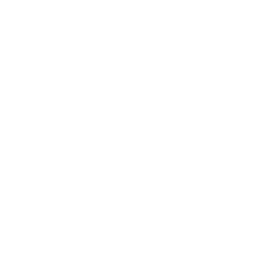
    * ...run through img2prompt outputs this prompt: `a black and white logo with the words so true, a raytraced image by Karl Ballmer, reddit, letterism, epic, creative commons attribution, 20 megapixels`
      * (Note that no reasonable person would describe this as a "raytraced image" or as "20 megapixels". Part of this is inaccuracy on the part of img2prompt; it is also evidence one *really* should experiment a lot)